# 数据采集

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["font.family"] = ["SimHei"]
import warnings
warnings.filterwarnings('ignore')

#加载
def load_data(file_path):
    """加载学生成绩数据集"""
    df = pd.read_csv(file_path)
    print("数据基本信息：")
    df.info()
    print("\n数据前5行：")
    print(df.head())
    return df

df = load_data('StudentPerformanceFactors.csv')

# 数据预处理

In [ ]:
def preprocess_data(df):
    """数据预处理函数"""
    #缺失值
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        df[col].fillna(df[col].mean(), inplace=True)
    
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    
    #去重
    print(f"\n原始数据行数: {df.shape[0]}")
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        df = df.drop_duplicates()
        print(f"删除了 {duplicates} 行重复数据")
    print(f"处理后数据行数: {df.shape[0]}")
    
    #特征编码
    df_encoded = df.copy()
    cat_cols = df_encoded.select_dtypes(include='object').columns.tolist()
    
    #对分类特征进行标签编码
    le = LabelEncoder()
    for col in cat_cols:
        df_encoded[col] = le.fit_transform(df_encoded[col])
    
    return df_encoded

#预处理
df_encoded = preprocess_data(df)

#特征相关性
print("\n特征与分数的相关性：")
correlation = df_encoded.corr()['Exam_Score'].sort_values(ascending=False)
print(correlation)

# 建模

In [ ]:
def prepare_data(df_encoded):
    """准备特征和目标变量"""
    X = df_encoded.drop('Exam_Score', axis=1)
    y = df_encoded['Exam_Score']
    
    #数据划分
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    #特征标准化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler


X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_data(df_encoded)
def train_and_evaluate_models(X_train, X_test, y_train, y_test, tuned=False, params=None):
    models = {
        "决策树回归": DecisionTreeRegressor(random_state=42),
        "随机森林回归": RandomForestRegressor(n_estimators=100, random_state=42) }
    
    if tuned and params:
        print("\n正在进行模型调优")
        for name in models.keys():
            models[name].set_params(**params[name])
            print(f"{name} 使用调优参数: {params[name]}")
    
    results = {}
    for name, model in models.items():
        #训练模型
        model.fit(X_train, y_train)
        #预测
        y_pred = model.predict(X_test)
        #评估指标
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {
            'model': model,
            'mse': mse,
            'rmse': rmse,
            'r2': r2,
            'predictions': y_pred }
        status = "调优后" if tuned else "调优前"
        print(f"\n{name} {status} 模型测试结果：")
        print(f"均方误差(MSE): {mse:.4f}")
        print(f"均方根误差(RMSE): {rmse:.4f}")
        print(f"决定系数(R²): {r2:.4f}")
    
    return results

# 模型测试

In [ ]:
def tune_models(X_train, y_train):
    """模型调优函数"""
    print("\n开始模型调优过程")
    
    # 决策树参数网格
    dt_params = {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4] }
    
    # 随机森林参数网格
    rf_params = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    
    # 决策树调优
    print("\n正在调优决策树")
    dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42),
                          dt_params,
                          cv=5,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1)
    dt_grid.fit(X_train, y_train)
    print("决策树最佳参数:", dt_grid.best_params_)
    
    # 随机森林调优
    print("\n正在调优随机森林")
    rf_grid = GridSearchCV(RandomForestRegressor(random_state=42),
                          rf_params,
                          cv=5,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1)
    rf_grid.fit(X_train, y_train)
    print("随机森林最佳参数:", rf_grid.best_params_)
    
    return {
        "决策树回归": dt_grid.best_params_,
        "随机森林回归": rf_grid.best_params_
    }

## 模型评估


调优前模型性能

决策树回归 调优前 模型测试结果：
均方误差(MSE): 10.8926
均方根误差(RMSE): 3.3004
决定系数(R²): 0.2294

随机森林回归 调优前 模型测试结果：
均方误差(MSE): 4.8381
均方根误差(RMSE): 2.1996
决定系数(R²): 0.6577

开始模型调优过程...

正在调优决策树...
决策树最佳参数: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}

正在调优随机森林...
随机森林最佳参数: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

调优后模型性能

正在进行模型调优...
决策树回归 使用调优参数: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
随机森林回归 使用调优参数: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

决策树回归 调优后 模型测试结果：
均方误差(MSE): 6.4134
均方根误差(RMSE): 2.5325
决定系数(R²): 0.5463

随机森林回归 调优后 模型测试结果：
均方误差(MSE): 4.6457
均方根误差(RMSE): 2.1554
决定系数(R²): 0.6713


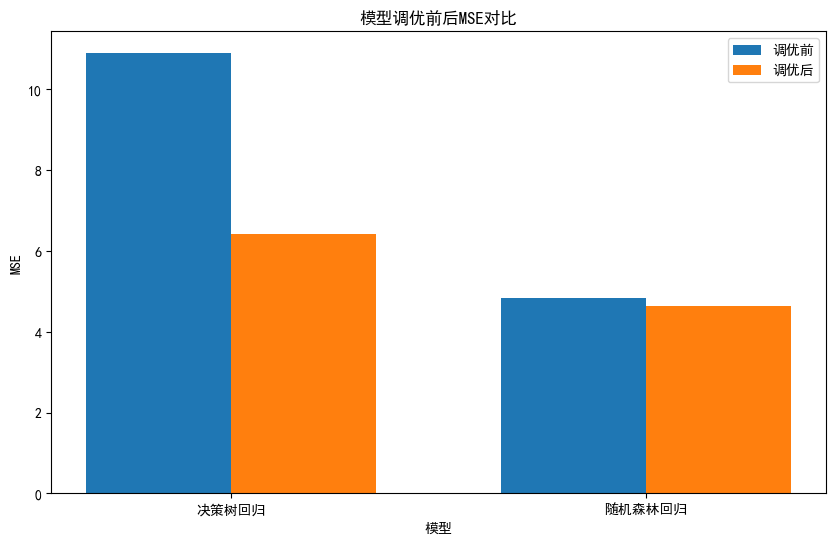

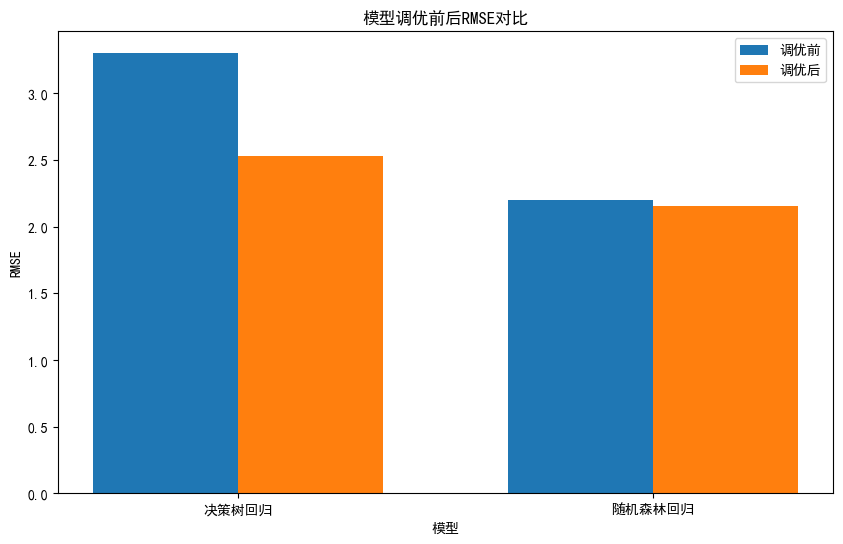

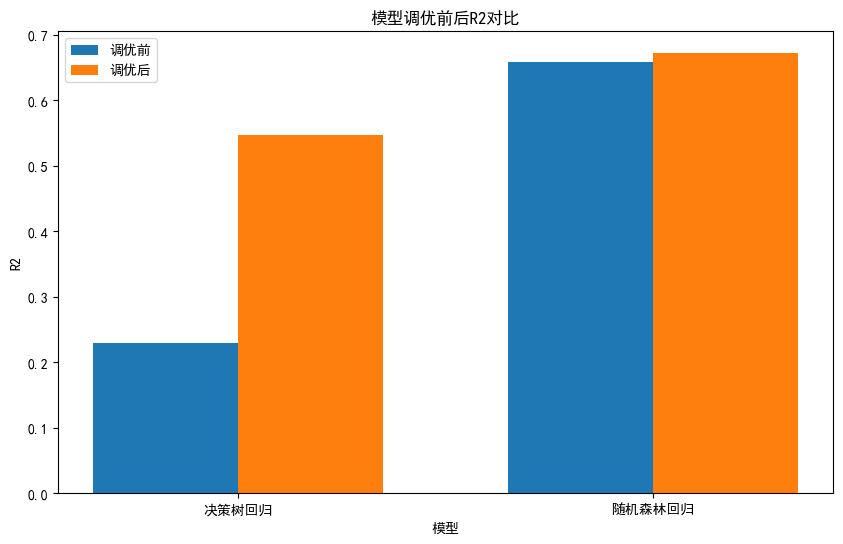


将分数转为分类评估（及格线：60分）：

决策树回归 模型分类评估：
准确率: 0.9917
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.99      1.00      1.00      1311

    accuracy                           0.99      1322
   macro avg       0.50      0.50      0.50      1322
weighted avg       0.98      0.99      0.99      1322



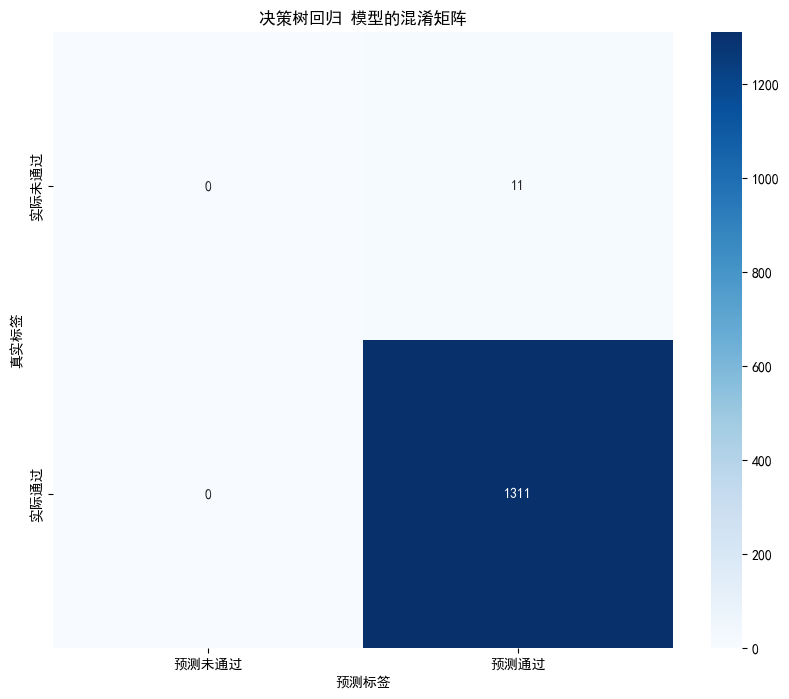


随机森林回归 模型分类评估：
准确率: 0.9947
              precision    recall  f1-score   support

           0       1.00      0.36      0.53        11
           1       0.99      1.00      1.00      1311

    accuracy                           0.99      1322
   macro avg       1.00      0.68      0.77      1322
weighted avg       0.99      0.99      0.99      1322



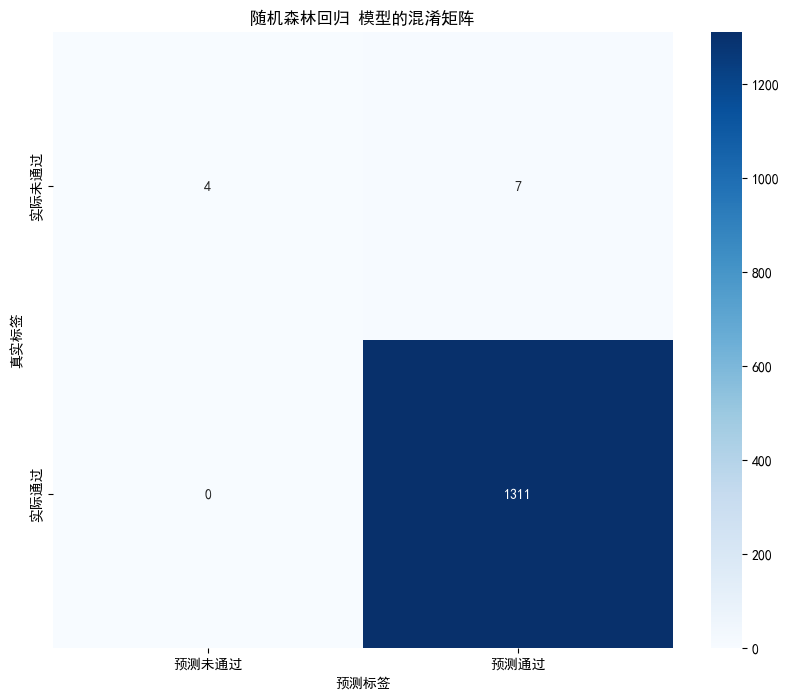

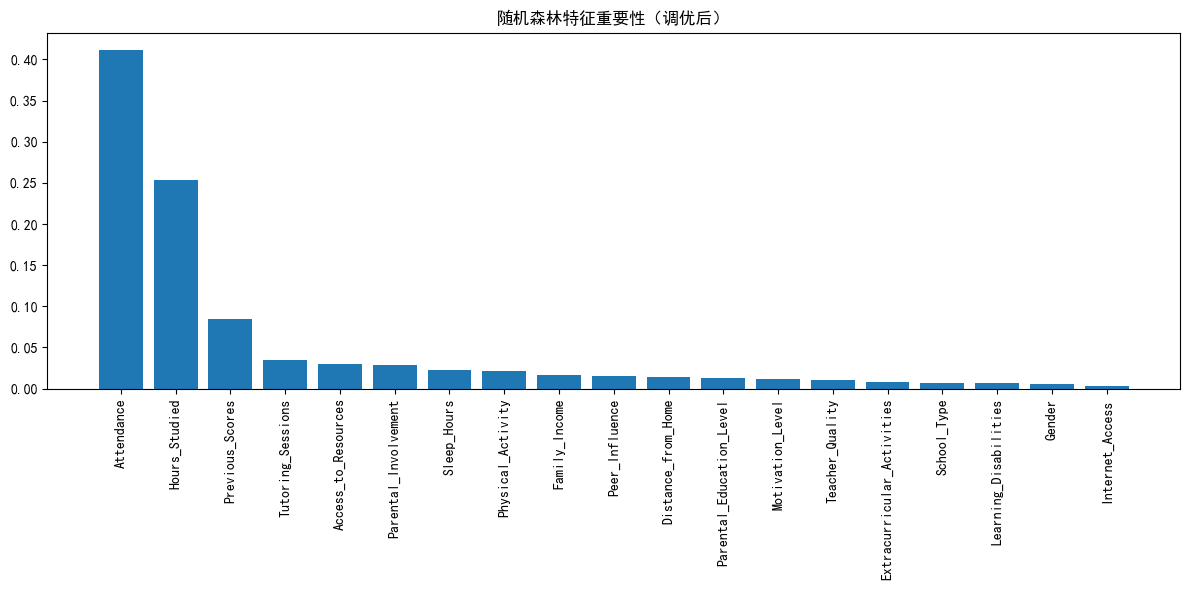

In [5]:
# 1. 调优前模型训练和评估
print("\n" + "="*50)
print("调优前模型性能")
print("="*50)
initial_results = train_and_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)

# 2. 进行模型调优
best_params = tune_models(X_train_scaled, y_train)

# 3. 调优后模型训练和评估
print("\n" + "="*50)
print("调优后模型性能")
print("="*50)
tuned_results = train_and_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test, 
                                         tuned=True, params=best_params)

# 4. 性能对比可视化
def plot_comparison(initial_results, tuned_results):
    """绘制调优前后对比图"""
    metrics = ['mse', 'rmse', 'r2']
    model_names = list(initial_results.keys())
    
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        initial_values = [initial_results[name][metric] for name in model_names]
        tuned_values = [tuned_results[name][metric] for name in model_names]
        
        x = np.arange(len(model_names))
        width = 0.35
        
        plt.bar(x - width/2, initial_values, width, label='调优前')
        plt.bar(x + width/2, tuned_values, width, label='调优后')
        
        plt.xlabel('模型')
        plt.ylabel(metric.upper())
        plt.title(f'模型调优前后{metric.upper()}对比')
        plt.xticks(x, model_names)
        plt.legend()
        plt.show()

plot_comparison(initial_results, tuned_results)

# 5. 评估调优后的模型（分类任务）
def evaluate_as_classifier(results, y_test, passing_score=60):
    """将回归结果转为分类评估"""
    print(f"\n将分数转为分类评估（及格线：{passing_score}分）：")
    
    for name, result in results.items():
        y_test_binary = (y_test >= passing_score).astype(int)
        y_pred_binary = (result['predictions'] >= passing_score).astype(int)
        
        accuracy = accuracy_score(y_test_binary, y_pred_binary)
        cm = confusion_matrix(y_test_binary, y_pred_binary)
        
        print(f"\n{name} 模型分类评估：")
        print(f"准确率: {accuracy:.4f}")
        print(classification_report(y_test_binary, y_pred_binary))
        
        # 混淆矩阵
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['预测未通过', '预测通过'],
                    yticklabels=['实际未通过', '实际通过'])
        plt.xlabel('预测标签')
        plt.ylabel('真实标签')
        plt.title(f'{name} 模型的混淆矩阵')
        plt.show()

# 使用调优后的模型进行分类评估
evaluate_as_classifier(tuned_results, y_test)

# 6. 特征重要性分析（调优后的随机森林）
def plot_feature_importance(model, feature_names):
    """绘制特征重要性"""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title("随机森林特征重要性（调优后）")
    plt.bar(range(len(feature_names)), importances[indices])
    plt.xticks(range(len(feature_names)), feature_names[indices], rotation=90)
    plt.tight_layout()
    plt.show()

# 绘制特征重要性
feature_names = df_encoded.drop('Exam_Score', axis=1).columns
plot_feature_importance(tuned_results["随机森林回归"]['model'], feature_names)

# 预测

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# 中英文特征名映射
feature_mapping = {
    'Hours_Studied': '学习时长',
    'Attendance': '出勤率',
    'Parental_Involvement': '家长参与度',
    'Access_to_Resources': '学习资源获取',
    'Extracurricular_Activities': '课外活动参与',
    'Sleep_Hours': '睡眠时间',
    'Previous_Scores': '先前成绩',
    'Motivation_Level': '学习动机水平',
    'Internet_Access': '网络接入情况',
    'Tutoring_Sessions': '辅导课程参与',
    'Family_Income': '家庭收入',
    'Teacher_Quality': '教师质量',
    'School_Type': '学校类型',
    'Peer_Influence': '同伴影响',
    'Physical_Activity': '体育活动量',
    'Learning_Disabilities': '学习障碍情况',
    'Gender': '性别',
    'Parental_Education_Level': '家长教育水平',
    'Distance_from_Home': '离家距离',
    'Exam_Score': '考试成绩',
    'Pass': '是否及格'
}

## 1.数据加载与预处理
def load_and_preprocess(file_path):
    #加载数据
    df = pd.read_csv(file_path)
    print("数据集中包含的列名:", df.columns.tolist())
    
    #添加中文名称
    for col in df.columns:
        if col in feature_mapping:
            df[feature_mapping[col]] = df[col]
    
    #缺失值
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        df[col].fillna(df[col].mean(), inplace=True)
    
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    
    #去重
    df = df.drop_duplicates()
    
    #创建是否及格的目标变量(60分及格)
    df['Pass'] = (df['Exam_Score'] >= 60).astype(int)
    df['是否及格'] = df['Pass']
    
    #特征编码
    le = LabelEncoder()
    cat_cols = df.select_dtypes(include='object').columns.tolist()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])
    
    return df

#预处理
df = load_and_preprocess('StudentPerformanceFactors.csv')

## 2特征选择与数据准备
# 定义学习习惯相关特征
learning_habit_features = [
    '学习时长',
    '出勤率',
    '家长参与度',
    '学习资源获取',
    '课外活动参与',
    '睡眠时间',
    '先前成绩',
    '学习动机水平',
    '网络接入情况',
    '辅导课程参与'
]

other_features = [
    '家庭收入',
    '教师质量',
    '学校类型',
    '同伴影响',
    '体育活动量',
    '学习障碍情况',
    '性别',
    '家长教育水平',
    '离家距离'
]

#合并特征
all_features = learning_habit_features + other_features

available_features = [f for f in all_features if f in df.columns]
print("\n可用的特征列:", available_features)

#选择要使用的特征
feature_choice = input(f"请输入要使用的特征(用逗号分隔，直接回车使用学习习惯特征): ") or ','.join(learning_habit_features)
features = [f.strip() for f in feature_choice.split(',') if f.strip() in df.columns]

if not features:
    features = [f for f in learning_habit_features if f in df.columns]
    print(f"没有选择有效特征，将使用默认的学习习惯特征: {features}")

print(f"\n最终使用的特征: {features}")

#查找对应的英文特征名
features_english = []
for feature in features:
    #查找中文特征对应的英文名称
    english_feature = next((k for k, v in feature_mapping.items() if v == feature), feature)
    features_english.append(english_feature)

X = df[features_english]
y = df['Pass']

#数据划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3.模型训练与预测
#随机森林分类器
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

#预测
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # 预测为及格的概率

## 4.模型评估
#准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"\n模型预测准确率: {accuracy:.4f}")
print("\n分类报告:")
print(classification_report(y_test, y_pred))

#混淆矩阵
cm = confusion_matrix(y_test, y_pred)
print("\n混淆矩阵:")
print(cm)

## 5.特征重要性
feature_importance = pd.DataFrame({
    '特征英文': features_english,
    '特征中文': features,
    '重要性': model.feature_importances_
}).sort_values(by='重要性', ascending=False)

print("\n特征重要性排序:")
print(feature_importance[['特征中文', '特征英文', '重要性']])

## 6预测示例
print("\n预测示例:")
sample_data = X_test_scaled[:5]  # 前5
sample_pred = model.predict(sample_data)
sample_pred_proba = model.predict_proba(sample_data)

for i in range(5):
    print(f"\n样本 {i+1}:")
    print(f"实际标签: {'及格' if y_test.iloc[i] == 1 else '不及格'}")
    print(f"预测标签: {'及格' if sample_pred[i] == 1 else '不及格'}")
    print(f"及格概率: {sample_pred_proba[i][1]:.2%}")
    print("特征值:")
    for j, feature in enumerate(features):
        english_feature = features_english[j]
        original_value = X_test.iloc[i][english_feature]
        print(f"  {feature} ({english_feature}): {original_value}")

数据集中包含的列名: ['Hours_Studied', 'Attendance', 'Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours', 'Previous_Scores', 'Motivation_Level', 'Internet_Access', 'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender', 'Exam_Score']

可用的特征列: ['学习时长', '出勤率', '家长参与度', '学习资源获取', '课外活动参与', '睡眠时间', '先前成绩', '学习动机水平', '网络接入情况', '辅导课程参与', '家庭收入', '教师质量', '学校类型', '同伴影响', '体育活动量', '学习障碍情况', '性别', '家长教育水平', '离家距离']


请输入要使用的特征(用逗号分隔，直接回车使用学习习惯特征):  学习时长,出勤率



最终使用的特征: ['学习时长', '出勤率']

模型预测准确率: 0.9894

分类报告:
              precision    recall  f1-score   support

           0       0.20      0.09      0.12        11
           1       0.99      1.00      0.99      1311

    accuracy                           0.99      1322
   macro avg       0.60      0.54      0.56      1322
weighted avg       0.99      0.99      0.99      1322


混淆矩阵:
[[   1   10]
 [   4 1307]]

特征重要性排序:
   特征中文           特征英文       重要性
0  学习时长  Hours_Studied  0.564889
1   出勤率     Attendance  0.435111

预测示例:

样本 1:
实际标签: 及格
预测标签: 及格
及格概率: 100.00%
特征值:
  学习时长 (Hours_Studied): 20
  出勤率 (Attendance): 71

样本 2:
实际标签: 及格
预测标签: 及格
及格概率: 100.00%
特征值:
  学习时长 (Hours_Studied): 22
  出勤率 (Attendance): 71

样本 3:
实际标签: 及格
预测标签: 及格
及格概率: 100.00%
特征值:
  学习时长 (Hours_Studied): 21
  出勤率 (Attendance): 91

样本 4:
实际标签: 及格
预测标签: 及格
及格概率: 100.00%
特征值:
  学习时长 (Hours_Studied): 12
  出勤率 (Attendance): 91

样本 5:
实际标签: 及格
预测标签: 及格
及格概率: 100.00%
特征值:
  学习时长 (Hours_Studied): 21
  出勤率 (Attendance): 63
